# Project 4 - Predict West Nile Virus

## 4. Modelling and Evaluation

## Content
- [Importing Data](#Importing-Data)
- [Modelling](#Modelling)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)

In [1]:
# # Install XGBoost model if required.
# !pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Importing Data

In [3]:
train = pd.read_csv('../assets/train_engineered.csv')
test = pd.read_csv('../assets/test_engineered.csv')

In [4]:
train.shape
test.shape

(8610, 61)

(116293, 60)

In [5]:
train.columns
test.columns

Index(['date', 'species', 'trap', 'latitude', 'longitude', 'wnvpresent',
       'nummosquitos', 'year', 'month', 'day', 'precip_avg', '14day_precip',
       '28day_precip', '90day_precip', 'temp_avg', '14day_tavg', '28day_tavg',
       '90day_tavg', 'tmin_avg', '14day_tmin', '28day_tmin', 'tmax_avg',
       '14day_tmax', '28day_tmax', 'dew_avg', '14day_dew', '28day_dew',
       'day_sin', 'day_cos', 'mth_sin', 'mth_cos', 'tmax', 'tmin', 'tavg',
       'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'preciptotal',
       'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed',
       'daylight', 'last_rained', 'tavgengineer', 'dewpointengineer',
       'wetbulbengineer', 'preciptotalengineer', 'heatengineer',
       'last_rainedengineer', 'proba_wnv', 'proba_num', 'species_weights',
       'month_weight', 'dead1', 'dead2', 'dead3', 'dead4'],
      dtype='object')

Index(['id', 'date', 'species', 'trap', 'latitude', 'longitude', 'year',
       'month', 'day', 'precip_avg', '14day_precip', '28day_precip',
       '90day_precip', 'temp_avg', '14day_tavg', '28day_tavg', '90day_tavg',
       'tmin_avg', '14day_tmin', '28day_tmin', 'tmax_avg', '14day_tmax',
       '28day_tmax', 'dew_avg', '14day_dew', '28day_dew', 'day_sin', 'day_cos',
       'mth_sin', 'mth_cos', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed', 'daylight', 'last_rained',
       'tavgengineer', 'dewpointengineer', 'wetbulbengineer',
       'preciptotalengineer', 'heatengineer', 'last_rainedengineer',
       'proba_wnv', 'proba_num', 'species_weights', 'month_weight', 'dead1',
       'dead2', 'dead3', 'dead4'],
      dtype='object')

In [6]:
train.head(5)

,date,species,trap,latitude,longitude,wnvpresent,nummosquitos,year,month,day,...,heatengineer,last_rainedengineer,proba_wnv,proba_num,species_weights,month_weight,dead1,dead2,dead3,dead4
0,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,0,1,2007,5,29,...,0.0,1.000000,0.492341,0.490732,0.491536,0.0,18.774527,18.101654,22.963275,19.945151
1,2007-05-29,CULEX RESTUANS,T048,41.867108,-87.654224,0,2,2007,5,29,...,0.0,1.414214,0.105033,0.173513,0.130855,0.0,18.774527,18.101654,22.963275,19.945151
2,2007-05-29,CULEX RESTUANS,T091,41.862292,-87.648860,0,1,2007,5,29,...,0.0,1.732051,0.105033,0.173513,0.130855,0.0,19.470424,18.797577,23.623311,19.460671
3,2007-05-29,CULEX RESTUANS,T049,41.896282,-87.655232,0,1,2007,5,29,...,0.0,2.000000,0.105033,0.173513,0.130855,0.0,16.307515,15.731053,21.375831,23.166622
4,2007-05-29,CULEX RESTUANS,T153,41.907645,-87.760886,0,1,2007,5,29,...,0.0,2.236068,0.105033,0.173513,0.130855,0.0,10.560762,9.658273,13.083923,25.344581


In [7]:
#drop species
#drop 'proba_wnv','proba_num', 'tavg','dewpoint','wetbulb','preciptotal' as they are feature engineered already
#drop trap
#drop nummosquitos, in train set

train.drop(['date', 'species', 'trap', 'nummosquitos', 'proba_wnv','proba_num'], axis=1, inplace=True)
test.drop(['date', 'species', 'trap', 'proba_wnv','proba_num'], axis=1, inplace=True)
train.columns
test.columns

Index(['latitude', 'longitude', 'wnvpresent', 'year', 'month', 'day',
       'precip_avg', '14day_precip', '28day_precip', '90day_precip',
       'temp_avg', '14day_tavg', '28day_tavg', '90day_tavg', 'tmin_avg',
       '14day_tmin', '28day_tmin', 'tmax_avg', '14day_tmax', '28day_tmax',
       'dew_avg', '14day_dew', '28day_dew', 'day_sin', 'day_cos', 'mth_sin',
       'mth_cos', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb',
       'heat', 'cool', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed',
       'resultdir', 'avgspeed', 'daylight', 'last_rained', 'tavgengineer',
       'dewpointengineer', 'wetbulbengineer', 'preciptotalengineer',
       'heatengineer', 'last_rainedengineer', 'species_weights',
       'month_weight', 'dead1', 'dead2', 'dead3', 'dead4'],
      dtype='object')

Index(['id', 'latitude', 'longitude', 'year', 'month', 'day', 'precip_avg',
       '14day_precip', '28day_precip', '90day_precip', 'temp_avg',
       '14day_tavg', '28day_tavg', '90day_tavg', 'tmin_avg', '14day_tmin',
       '28day_tmin', 'tmax_avg', '14day_tmax', '28day_tmax', 'dew_avg',
       '14day_dew', '28day_dew', 'day_sin', 'day_cos', 'mth_sin', 'mth_cos',
       'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'daylight', 'last_rained', 'tavgengineer',
       'dewpointengineer', 'wetbulbengineer', 'preciptotalengineer',
       'heatengineer', 'last_rainedengineer', 'species_weights',
       'month_weight', 'dead1', 'dead2', 'dead3', 'dead4'],
      dtype='object')

In [8]:
#drop year month day as they are feature engineered already

train.drop(['year', 'month', 'day', 'tavg','dewpoint','wetbulb','preciptotal'], axis=1, inplace=True)
test.drop(['year', 'month', 'day', 'tavg','dewpoint','wetbulb','preciptotal'], axis=1, inplace=True)
train.columns
test.columns

Index(['latitude', 'longitude', 'wnvpresent', 'precip_avg', '14day_precip',
       '28day_precip', '90day_precip', 'temp_avg', '14day_tavg', '28day_tavg',
       '90day_tavg', 'tmin_avg', '14day_tmin', '28day_tmin', 'tmax_avg',
       '14day_tmax', '28day_tmax', 'dew_avg', '14day_dew', '28day_dew',
       'day_sin', 'day_cos', 'mth_sin', 'mth_cos', 'tmax', 'tmin', 'depart',
       'heat', 'cool', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'daylight', 'last_rained', 'tavgengineer',
       'dewpointengineer', 'wetbulbengineer', 'preciptotalengineer',
       'heatengineer', 'last_rainedengineer', 'species_weights',
       'month_weight', 'dead1', 'dead2', 'dead3', 'dead4'],
      dtype='object')

Index(['id', 'latitude', 'longitude', 'precip_avg', '14day_precip',
       '28day_precip', '90day_precip', 'temp_avg', '14day_tavg', '28day_tavg',
       '90day_tavg', 'tmin_avg', '14day_tmin', '28day_tmin', 'tmax_avg',
       '14day_tmax', '28day_tmax', 'dew_avg', '14day_dew', '28day_dew',
       'day_sin', 'day_cos', 'mth_sin', 'mth_cos', 'tmax', 'tmin', 'depart',
       'heat', 'cool', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'daylight', 'last_rained', 'tavgengineer',
       'dewpointengineer', 'wetbulbengineer', 'preciptotalengineer',
       'heatengineer', 'last_rainedengineer', 'species_weights',
       'month_weight', 'dead1', 'dead2', 'dead3', 'dead4'],
      dtype='object')

In [9]:
X = train[[x for x in train.columns if x not in ['wnvpresent']]]
y = train['wnvpresent']

In [10]:
X.columns

Index(['latitude', 'longitude', 'precip_avg', '14day_precip', '28day_precip',
       '90day_precip', 'temp_avg', '14day_tavg', '28day_tavg', '90day_tavg',
       'tmin_avg', '14day_tmin', '28day_tmin', 'tmax_avg', '14day_tmax',
       '28day_tmax', 'dew_avg', '14day_dew', '28day_dew', 'day_sin', 'day_cos',
       'mth_sin', 'mth_cos', 'tmax', 'tmin', 'depart', 'heat', 'cool',
       'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed',
       'daylight', 'last_rained', 'tavgengineer', 'dewpointengineer',
       'wetbulbengineer', 'preciptotalengineer', 'heatengineer',
       'last_rainedengineer', 'species_weights', 'month_weight', 'dead1',
       'dead2', 'dead3', 'dead4'],
      dtype='object')

In [11]:
X_test = test[[x for x in test.columns if x not in ['id']]]

In [12]:
X_test.columns

Index(['latitude', 'longitude', 'precip_avg', '14day_precip', '28day_precip',
       '90day_precip', 'temp_avg', '14day_tavg', '28day_tavg', '90day_tavg',
       'tmin_avg', '14day_tmin', '28day_tmin', 'tmax_avg', '14day_tmax',
       '28day_tmax', 'dew_avg', '14day_dew', '28day_dew', 'day_sin', 'day_cos',
       'mth_sin', 'mth_cos', 'tmax', 'tmin', 'depart', 'heat', 'cool',
       'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed',
       'daylight', 'last_rained', 'tavgengineer', 'dewpointengineer',
       'wetbulbengineer', 'preciptotalengineer', 'heatengineer',
       'last_rainedengineer', 'species_weights', 'month_weight', 'dead1',
       'dead2', 'dead3', 'dead4'],
      dtype='object')

In [13]:
#Train test split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state = 42)

In [14]:
# Our scorer based on roc_auc_score
scorers = {'precision_score': make_scorer(precision_score),
           'recall_score': make_scorer(recall_score),
           'accuracy_score': make_scorer(accuracy_score),
           'f1_score': make_scorer(f1_score),
           'roc_auc_score': make_scorer(roc_auc_score, needs_threshold=True)
          }

In [15]:
#Set stratified k-fold for cross validation.
#we will use stratified k-fold since it is more suitable for binary classification.

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
ss = StandardScaler()

#fit
scaler = ss.fit(X_train)

#transform
X_train_ss = ss.transform(X_train) 
X_val_ss = ss.transform(X_val) 
X_test_ss = ss.transform(X_test) 

## Modelling

In [17]:
#make a function that prints evaluation metrics score
def evaluation_metrics(model):
    y_pred = model.predict(X_val_ss)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    print('False Negatives:', fn)
    print('Recall: {}'.format(round(metrics.recall_score(y_val, y_pred), 4)))
    print('Specificity: {}'.format(round(tn/(tn+fp),4)))

In [18]:
#make a function that prints the model score
def print_score(grid_model):
    print('Train\'s ROC_AUC score: {}'.format(round(grid_model.score(X_train_ss, y_train),4)))
    print('Best ROC_AUC score from GridSearch: {}'.format(round(grid_model.best_score_,4)))
    print('Difference in ROC_AUC scores between train and best: {}'.format(round(grid_model.score(X_train_ss, y_train) - grid_model.best_score_,4)))
    print('Validation\'s ROC_AUC score: {}'.format(round(grid_model.score(X_val_ss, y_val),4)))

In [19]:
#for final model section:
#make a function that prints all classification metrics, AUC-ROC + TN, FP, FN, TP
def all_metrics(model):
    y_pred = model.predict(X_val_ss)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    print("True Negatives: " + str(tn))
    print("False Positives: " + str(fp))
    print("False Negatives: " + str(fn))
    print("True Positives: " + str(tp))
    print()
    print('--------------------------------')
    print()
    print('Accuracy: {}'.format(round(metrics.accuracy_score(y_val, y_pred), 4)))
    print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
    print('Precision: {}'.format(round(metrics.precision_score(y_val, y_pred), 4)))
    print('Recall: {}'.format(round(metrics.recall_score(y_val, y_pred), 4)))
    print('Specificity: {}'.format(round(tn/(tn+fp),4)))
    #get roc auc score
    model_proba = [i[1] for i in model.predict_proba(X_val_ss)]
    print('ROC_AUC score on Validation Set: {}'.format(round(roc_auc_score(y_val, model_proba), 4)))

### Our Baseline: Logistic Regression

In [20]:
pipe_lr = Pipeline([('lr', LogisticRegression())])

In [21]:
pipe_params_lr = {'lr__penalty':['l1','l2'],
                  'lr__solver':['liblinear'],
                  'lr__C':np.logspace(-2, 1, 10)
                  }

gs_lr = GridSearchCV(pipe_lr, param_grid=pipe_params_lr, cv=skf, scoring=scorers, refit='roc_auc_score', n_jobs=-1, verbose=1)
gs_lr.fit(X_train_ss, y_train)
gs_lr.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:   16.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,
        0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ]),
                         'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['liblinear']},
             refit='roc_auc_score',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score),
                      'roc_auc_score': make_scorer(roc_auc_score, needs_threshold=True)},
             verbose=1)

{'lr__C': 2.154434690031882, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}

In [22]:
print_score(gs_lr)

Train's ROC_AUC score: 0.8368
Best ROC_AUC score from GridSearch: 0.8176
Difference in ROC_AUC scores between train and best: 0.0192
Validation's ROC_AUC score: 0.8526


In [23]:
evaluation_metrics(gs_lr)

False Negatives: 114
Recall: 0.0
Specificity: 1.0


### Random Forest Classifier

In [24]:
pipe_rf = Pipeline([('rf', RandomForestClassifier())])

In [25]:
pipe_params_rf = {'rf__class_weight' : ['balanced', 'balanced_subsample'],
                  'rf__min_samples_leaf': [40, 45, 50],
                  'rf__n_estimators': [240, 260, 280],
                  'rf__random_state': [42]
                  }

gs_rf = GridSearchCV(pipe_rf, param_grid=pipe_params_rf, cv=skf, scoring=scorers, refit='roc_auc_score', n_jobs=-1, verbose=1)
gs_rf.fit(X_train_ss, y_train)
gs_rf.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__class_weight': ['balanced', 'balanced_subsample'],
                         'rf__min_samples_leaf': [40, 45, 50],
                         'rf__n_estimators': [240, 260, 280],
                         'rf__random_state': [42]},
             refit='roc_auc_score',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score),
                      'roc_auc_score': make_scorer(roc_auc_score, needs_threshold=True)},
             verbose=1)

{'rf__class_weight': 'balanced',
 'rf__min_samples_leaf': 45,
 'rf__n_estimators': 260,
 'rf__random_state': 42}

In [26]:
print_score(gs_rf)

Train's ROC_AUC score: 0.9009
Best ROC_AUC score from GridSearch: 0.8367
Difference in ROC_AUC scores between train and best: 0.0642
Validation's ROC_AUC score: 0.8617


In [27]:
evaluation_metrics(gs_rf)

False Negatives: 19
Recall: 0.8333
Specificity: 0.7641


### XGBoost

In [28]:
pipe_xgc = Pipeline([('xgc', XGBClassifier())])

In [29]:
pipe_params_xgc = {'xgc__colsample_bytree' : [0.5],
                   'xgc__learning_rate' : [0.1],
                   'xgc__max_depth' : [3],
                   'xgc__n_estimators' : [500],
                   'xgc__reg_alpha' : [2.5, 3, 3.5],
                   'xgc__reg_lambda' : [10, 12, 14],
                   'xgc__scale_pos_weight': [18], 
                   'xgc__subsample' : [0.5]
                  }

gs_xgc = GridSearchCV(pipe_xgc, param_grid=pipe_params_xgc, cv=skf, scoring=scorers, refit='roc_auc_score', n_jobs=-1, verbose=1)
gs_xgc.fit(X_train_ss, y_train)
gs_xgc.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('xgc',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                              

{'xgc__colsample_bytree': 0.5,
 'xgc__learning_rate': 0.1,
 'xgc__max_depth': 3,
 'xgc__n_estimators': 500,
 'xgc__reg_alpha': 2.5,
 'xgc__reg_lambda': 12,
 'xgc__scale_pos_weight': 18,
 'xgc__subsample': 0.5}

In [30]:
print_score(gs_xgc)

Train's ROC_AUC score: 0.9613
Best ROC_AUC score from GridSearch: 0.8345
Difference in ROC_AUC scores between train and best: 0.1268
Validation's ROC_AUC score: 0.8698


In [31]:
evaluation_metrics(gs_xgc)

False Negatives: 32
Recall: 0.7193
Specificity: 0.848


## Model Selection

| Model| Train's ROC_AUC| Best ROC_AUC| Score Difference|Recall|Specificity|False Negatives|Validation's ROC_AUC
|----|---- |----  |---- |----|----|----|----|
| Logistic Regression (Baseline)| 0.8368| 0.8176| 0.0192| 0|1|114|0.8526
| Random Forest| 0.9009| 0.8367| 0.0642| 0.8333|0.7641|19|0.8617
| XGBoost| 0.9606| 0.8338| 0.1268| 0.7281|0.8411|31|0.8741

Since our datasets experience imbalanced classes (and our Kaggle entry would also be evaluated based on the ROC_AUC metric), we have decided to evaluate our model mainly based on their ROC_AUC scores. Looking at the scores for all three models, it appears that the ROC_AUC scores of both Random Forest (RF) and XGBoost (XG) have exceeded the ROC_AUC of our baseline model, Logistic Regression. This is evident by a ROC_AUC score of 0.8367 and 0.8338 for RF and XG respectively as compared to Logistic Regression's ROC_AUC score of 0.8176.

Hence, we will only be choosing our final model between RF and XG.

| Model| Train's ROC_AUC| Best ROC_AUC| Score Difference|Recall|Specificity|False Negatives|Validation's ROC_AUC
|----|---- |----  |---- |----|----|----|----|
| Random Forest| 0.9009| 0.8367| 0.0642| 0.8333|0.7641|19|0.8617
| XGBoost| 0.9606| 0.8338| 0.1268| 0.7281|0.8411|31|0.8741

Looking at the ROC_AUC scores for the RF and XG models, it appears that the ROC_AUC scores for both models are very similar, with RF's model only very slightly edging out XG's model by a slight ROC_AUC score difference of 0.0029.
However, when comparing the difference in ROC_AUC scores between the train and cross validation scores, RF has a much smaller ROC_AUC difference of 0.0642 as compared to XG's 0.1268, which means that the RF model experiences less of an overfit.

Since the West Nile Virus (WNV) is viewed as an increasing public health threat in Chicago<sup>[[1]](https://www.govtech.com/fs/data/Chicago-Turns-to-Predictive-Analytics-to-Map-West-Nile-Threat.html)</sup>, we have decided to look at their recall rates (and false negatives) as well, with the aim of choosing a model that maximises the recall rates while minimising the false negatives. This is because we want to minimise the areas that are not predicted by the model to have WNV but in reality actually have evidence(s) of WNV).

Hence, comparing the recall rates of both models, RF's recall score exceeds that of XG (RF's 0.8333 compared to XG's 0.7281).

Comparing the ROC_AUC scores of both models with their recall rates, we have decided to choose the Random Forest model as our final prediction model.

## Model Evaluation

### Our Final Model

|Model| Train's ROC_AUC| Best ROC_AUC| Score Difference|True Negatives|False Negatives|Recall|Specificity| Validation's ROC_AUC
|----|---- |----  |---- |----|----|----|----|----|
| Random Forest| 0.9009| 0.8367	| 0.0642|1558|19|0.8333|0.7641|0.8617|

In [32]:
#running the our chosen model (Random Forest) with optimal parameters
rf = gs_rf.best_estimator_.named_steps["rf"]

In [33]:
all_metrics(rf)

True Negatives: 1558
False Positives: 481
False Negatives: 19
True Positives: 95

--------------------------------

Accuracy: 0.7678
Misclassification rate: 0.2322
Precision: 0.1649
Recall: 0.8333
Specificity: 0.7641
ROC_AUC score on Validation Set: 0.8617


Text(0.5, 15.0, 'true label')

Text(91.68, 0.5, 'predicted label')

Text(0.5, 1.0, 'Confusion Matrix')

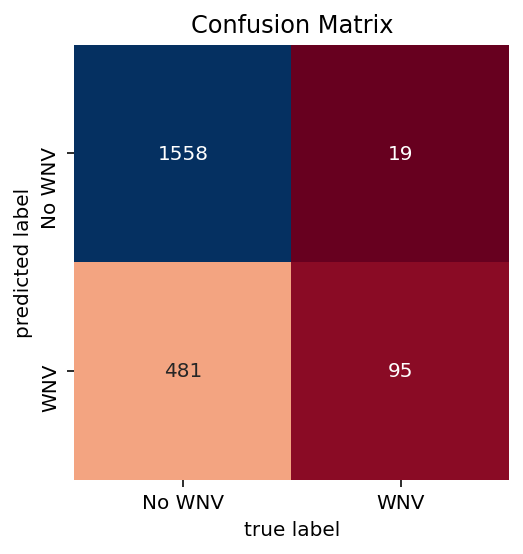

In [34]:
#Plot confusion matrix
y_pred = rf.predict(X_val_ss)
mat = confusion_matrix(y_val, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap='RdBu', cbar=False,
           xticklabels=['No WNV', 'WNV'], yticklabels=['No WNV', 'WNV'])

plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix')

In [35]:
pred_proba = [i[1] for i in rf.predict_proba(X_val_ss)] 
pred_df = pd.DataFrame({'true_values': y_val,
                        'pred_probs':pred_proba})

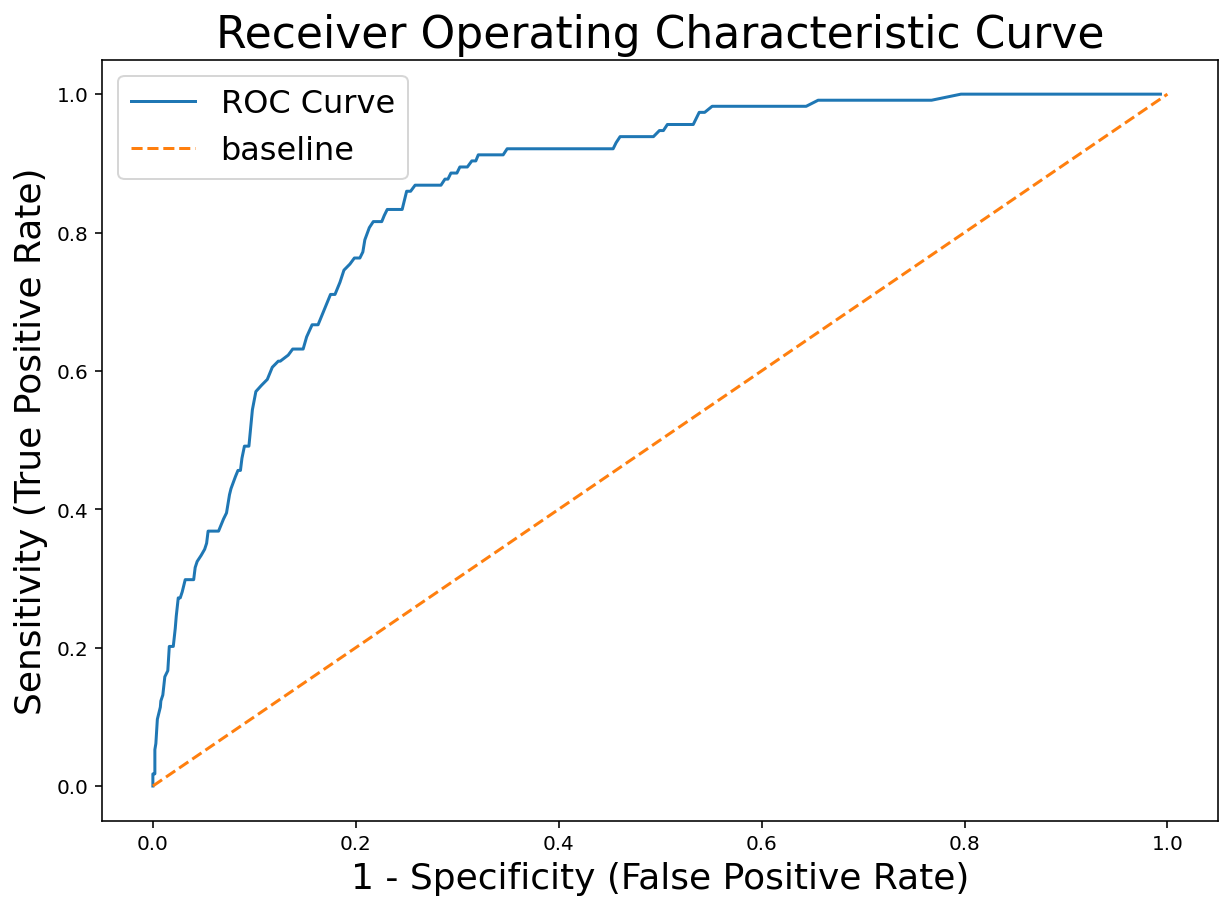

In [36]:
# Plot ROC curve
# Create figure.
plt.figure(figsize = (10,7))
# Create threshold values.
thresholds = np.linspace(0, 1, 200)
# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')
# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')
# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=18)
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=18)
# Create legend.
plt.legend(fontsize=16);

With a relatively high ROC_AUC score of 0.8617, this means that our model has good measure of separability
and has a huge AUC area under the ROC curve. A high recall score of 0.8333 tells us that out of all 'does not contain WNV' predictions made, 83.33% of the predictions (1558) were made correctly with only a fairly small 16.67% (19 predictions) of predictions made wrongly to not contain any WNV. With high recall rates, this means that this model minimises false negatives (as evident by the low number of false negatives: 19), which can definitely help in the curb of the West Nile Virus.

The specificity score of 0.7641 is fairly high as well, which means that among all 'does not contain-WNV' predictions made by the model, 76.41% (1558) of the predictions were correct. 

### Interpretation of Model

In [37]:
#function to get the top 25 most important features
def get_important_features(model):
    features = X_train.columns
    zipped = list(zip(features, model.feature_importances_))
    sorted_zip = sorted(zipped, key=lambda t: t[1], reverse=True)
    dataframe = pd.DataFrame(columns = ['feature', 'importance'])
    for x, y in sorted_zip[:25]:
        dataframe = dataframe.append(pd.Series([x, y],index =dataframe.columns), ignore_index=True)
    return dataframe

In [38]:
#function to plot the most important features
def plot_feature_importance(data, title):
    sns.set(rc={'figure.figsize':(12,9)})
    sns.barplot(x=data['importance'], y=data['feature'])
    plt.title(title, fontsize=12);
    plt.ylabel('Features', fontsize=10)
    plt.xlabel('Relative Feature Importance', fontsize=10)

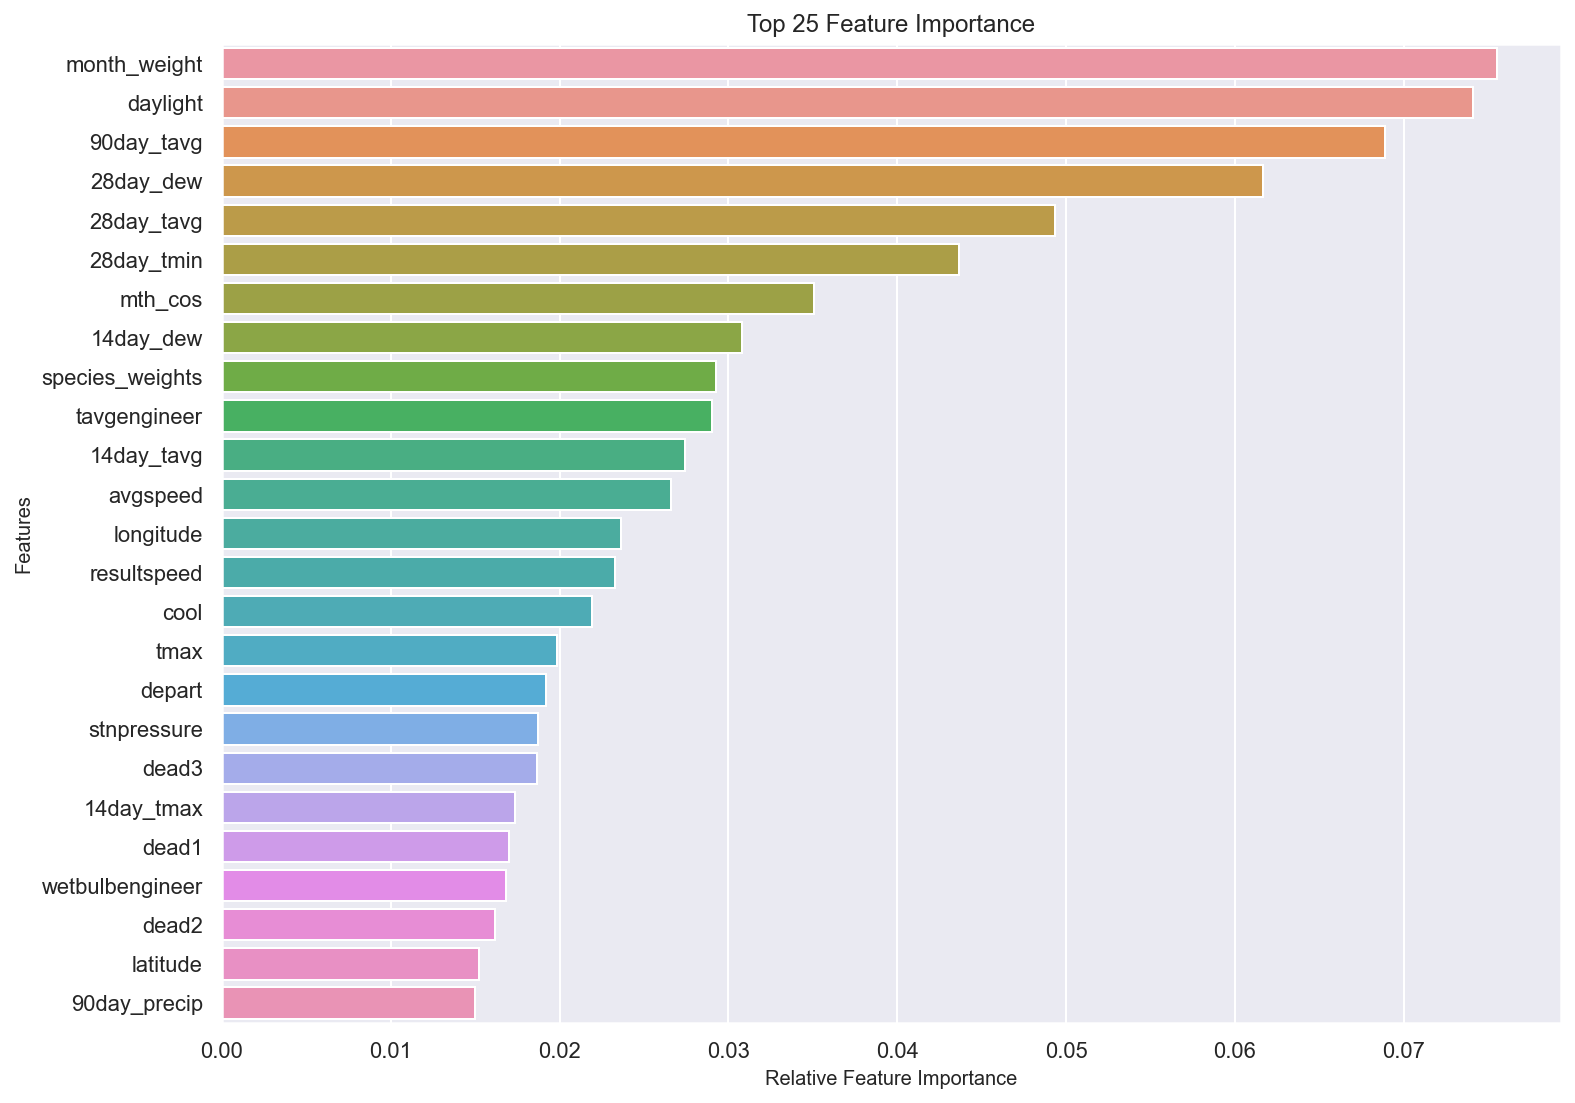

In [39]:
important_features = get_important_features(rf)
plot_feature_importance(important_features, 'Top 25 Feature Importance')

It appears that the features highly prioritised by our model are related to the weather conditions (temperature, dew, wind speed, pressure etc.), the season (months) and the location (longitude and how far it is from a WNV hot spot).

Among the top 25 are two month-related features - the month_weight (probability of WNV per month), the month_cos (month calculated as a cyclical variable through cosine) and the total daylight period as experienced by a location (daylight). With the West Nile Virus known to appear more during the summer months<sup>[[2]](http://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health)</sup>, this definitely explains why month is a highly prioritised variable by the model.

Numerous weather-related variables are also present in the top 25, such as the average daily temperature (tavgengineer), the 90 day rolling average of average temperature (90_day_tavg), the 28 day rolling averages of dewpoints, average temperature and lowest temperature (28day_dew, 28day_tavg, 28day_tmin), the 14 day rolling averages of dewpoint, average temperature and maximum temperature (14day_dew, 14day_tavg, 14day_tmax), wind speed (resultspeed, avgspeed), the daily maximum temperature (tmax), location pressure (stnpressure) and whether it is currently in the cool season (cool). Since the weather conditions of a location<sup>[[3]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4342965/)</sup>, especially the temperature of a location<sup>[[4]](https://parasitesandvectors.biomedcentral.com/articles/10.1186/1756-3305-3-19)</sup>, highly affects the presence of West Nile virus at a certain location, this definitely corresponds to the strong presence of weather-related variables as prioritised by our model.

Similarly, the total daylight period as experienced by a location (daylight) is also highly ranked at no. 2. Since West Nile mosquitos are known to be more active at night <sup>[[5]](http://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health)</sup> and daylight is known to be longer in summer months, this definitely translates to daylight time's high feature importance as explained by our model. 

Besides that, there are also several location-related variables ranked among the top 25, such as the location's longitude, latitude, and the distance of a certain location from various West Nile Virus hot spots (WNV hot spot 1, 2 and 3). Since the West Nile Virus case diagnosis includes whether a person lives near an area where infected WNV mosquitos have been found<sup>[[6]](https://kidshealth.org/en/parents/west-nile.html)</sup>, this definitely explains why the distance to a West Nile Virus hotspot would affect whether a location is found to have WNV cases since mosquitos with WNV will usually be located at WNV hotspots and their surrounding areas.


### Kaggle Submission

In [40]:
pred_proba_rf = [i[1] for i in rf.predict_proba(X_test_ss)] 
Id = test['id'].tolist()
submission = pd.DataFrame(pred_proba_rf, columns=['WnvPresent'])
submission['Id'] = Id
submission = submission[['Id', 'WnvPresent']]

submission.to_csv('../assets/submission_kaggle.csv', index=False)

### References


https://www.govtech.com/fs/data/Chicago-Turns-to-Predictive-Analytics-to-Map-West-Nile-Threat.html<br>
http://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health<br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4342965/<br>
https://parasitesandvectors.biomedcentral.com/articles/10.1186/1756-3305-3-19<br>
http://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health<br>
https://kidshealth.org/en/parents/west-nile.html